# Load libraries needed

In [740]:
#Pandas
import pandas as pd
from pandas import ExcelWriter, ExcelFile

#Numpy
import numpy as np

#NLTK
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop = stopwords.words('english')
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

#SkLearn
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC

#Other
import string
import seaborn as sns
import yellowbrick as yb
from yellowbrick.classifier import ClassificationReport

#Word Cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline

#Gensim
import gensim

df = pd.read_excel('list_project_updated.xlsx')

# Cute Word Cloud

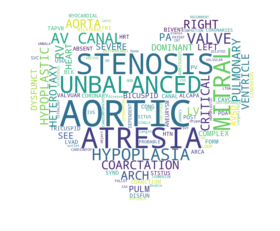

In [745]:
data = df.dropna(subset=['CHD_OTHSP'])
data2 = data.dropna(subset=['SPECOTH'])

# Start with one review:
text = str(data2.CHD_OTHSP)
text2 = str(data2.SPECOTH)
all = text+text2
    
heart_mask = np.array(Image.open("heart2.jpg"))
                    
wordcloud = WordCloud(mask=heart_mask,background_color="white").generate(text)

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear",)
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [407]:
#Check to make sure we have the columns and it imported 
print(df.columns)

#The categorical variables needed to one hot encode
cat_var = [key for key in dict(df.dtypes) if dict(df.dtypes)[key] in ['object']] 

#Do not want to hot encode these.  
cat_var.remove('CHD_OTHSP')
cat_var.remove('SPECOTH')

#show the categorical
print(cat_var)

Index(['Unnamed: 0', 'AGE_LISTING', 'AGE_TXPL', 'STATLIST', 'SLVAD', 'SLECMO',
       'SLVENT', 'HXARRYTH', 'HXCPR', 'HXDIAB',
       ...
       'LS_SURG_TRUNCUS', 'LS_SURG_VALVE', 'LS_SURG_VSD', 'LS_SURG_OTHER',
       'GRAFT_LOSS', 'INT_GRAFT_LOSS', 'LSNYHA_T', 'LSRHFCL_T', 'PATIENT_ID',
       'HETEROTAXY'],
      dtype='object', length=226)
['STATLIST', 'SLINODS', 'SEX', 'TXSTAT', 'DONORSEX', 'STATUS_LISTING', 'STATUS_TXPL', 'LSNYHA_T', 'LSRHFCL_T']


# Prepare Data 

In [408]:
#This unnamed column gets added as an index from importing with pandas, not sure how to drop it in the 
#import so just dropping it here
df.drop(df.filter(regex="Unname"),axis=1, inplace=True)

#Looking at the data specs
print(df.shape)
print(df.head())
print(df.describe())

(9204, 225)
   AGE_LISTING   AGE_TXPL STATLIST  SLVAD  SLECMO  SLVENT  HXARRYTH  HXCPR  \
0    15.855219  16.046873        1    0.0     0.0     0.0       1.0    NaN   
1     5.065128   5.100721        1    0.0     0.0     0.0       0.0    NaN   
2     9.089851   9.278767        2    0.0     0.0     0.0       0.0    NaN   
3     0.722807   1.136231        2    0.0     0.0     0.0       0.0    NaN   
4     0.032855        NaN        1    0.0     0.0     1.0       1.0    NaN   

   HXDIAB  HXGI  ...  LS_SURG_TRUNCUS  LS_SURG_VALVE  LS_SURG_VSD  \
0     0.0   0.0  ...                0              0            0   
1     0.0   0.0  ...                0              0            0   
2     0.0   0.0  ...                0              0            0   
3     0.0   0.0  ...                0              0            0   
4     0.0   0.0  ...                0              0            0   

   LS_SURG_OTHER  GRAFT_LOSS  INT_GRAFT_LOSS  LSNYHA_T  LSRHFCL_T  PATIENT_ID  \
0              0       

In [971]:
#One hot encode everything
df_processed = pd.get_dummies(df, prefix_sep="_",columns=cat_var)

#Text variables to drop from the first model
text = [key for key in dict(df_processed.dtypes) if dict(df_processed.dtypes)[key] in ['object']] 

#These are the text variables now because we transformed the others
print(text)

#Storing all continuous variables
con_var = [key for key in dict(df_processed.dtypes) if dict(df_processed.dtypes)[key] not in ['object']] 

#We don't want this in any of the models, it's useless information
con_var.remove('PATIENT_ID')

#Look at how many people are flagged as Heterotaxy to ensure it was the amount Tobias thought
print(df_processed['GRAFT_LOSS'].value_counts())

#Set to only heterotaxy
df_filtered_list = df_processed[df_processed['HETEROTAXY'] == 1]

#Set to transplanted heterotaxy patients
df_filtered_hetero = df_filtered_list[df_filtered_list['WAITLIST_OUTCOME'] == 1]

#Set to transplant patients overall
df_filtered_tx = df_processed[df_processed['WAITLIST_OUTCOME'] == 1]

#Set to CHD patients
df_filtered_chd = df_processed[df_processed['DIAGNOSIS'] == 2]

#Set to tx CHD patients
df_filtered_tx_chd = df_filtered_chd[df_filtered_chd['WAITLIST_OUTCOME'] == 1]

#IGNORE MOST OF THE DATASETS I MADE I WAS JUST DOING THEM TO CHECK COUNTS FOR THE FLOWCHART IN THE POSTER

print(df_processed.shape)
print(df_filtered_list.shape)
print(df_filtered_hetero.shape)
print(df_filtered_tx.shape)
print(df_filtered_chd.shape)
print(df_filtered_tx_chd.shape)

['SPECOTH', 'CHD_OTHSP']
0.0    5121
1.0    1656
Name: GRAFT_LOSS, dtype: int64
(9204, 251)
(207, 251)
(141, 251)
(6670, 251)
(4814, 251)
(3261, 251)


In [985]:
#Model without text fields
#Drop the text fields
df_model1 = df_filtered_hetero.drop(text,axis=1)

In [986]:
df_model1

#Look at missing
def missing(dff):
    print (round((dff.isnull().sum() * 100/ len(dff)),2).sort_values(ascending=False))

# #This is an issue
# missing(df_model1)

#Eliminate missing data that is more than 20%
filter_missing = df_model1[df_model1.columns[df_model1.isnull().mean() < 0.2]]

missing(filter_missing)


LCREAT_R                     16.31
CHD_HETER                    12.06
CHD_DILV                     11.35
CHD_LVOTOAS                  11.35
CHD_TAPVR                    11.35
CHD_TRIAT                    11.35
CHD_HRH                      11.35
SLVENT                       11.35
HXSHOCK                       8.51
HXCPR                         8.51
TXDOBUT                       7.09
TXISUPRO                      7.09
TXO2                          7.09
TXDOPA                        7.09
TXNPRUSS                      7.09
TXNITRO                       7.09
TXPGE                         7.09
TXVENT                        5.67
eGFR_TXPL                     4.26
HXMED                         4.26
BSA_LISTING                   3.55
DONISCH                       2.84
HEIGHT_TXPL                   2.84
TXBUN_R                       2.84
BSA_TXPL                      2.84
BMI_TXPL                      2.84
BSA_DONOR                     2.84
HEIGHT_DONOR                  2.84
WEIGHT_DONOR        

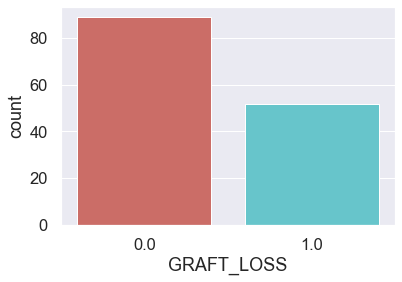

In [987]:
#Impute with the median, I just randomly chose this...could do whatever.
df_imp = filter_missing.fillna(filter_missing.median())

df_imp

#Huge class imbalacnce
sns.set(font_scale=1.5)
countplt=sns.countplot(x='GRAFT_LOSS', data=df_imp, palette ='hls')
plt.show()


# Prepare Data with Test Train Split

In [989]:
#Top 15 features always requested by Dr. Kirklin to use in models
#Only using 15 because it was always said to me that you need roughly 1 covariate for every 3 events 
covariate_list = ['AGE_LISTING','AGE_TXPL','SEX_F','STATUS_TXPL_Priority','RRACE_B','LCREAT_R','TXCREAT_R','BSA_DONOR','DONORSEX_F','SLECMO','TXIVINO','BSA_TXPL','HXMED','TXSTAT_1A','DONISCH']

#select a few
cols = [col for col in df_imp.columns if col in covariate_list]

#The data with all columns but target
data = df_imp[cols]

#The predictor
target = df_imp['GRAFT_LOSS']

#Split the data
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.3)

#Print dimensions
print(data_train.shape)
print(data_test.shape)
print(target_train.shape)
print(target_test.shape)



(98, 15)
(43, 15)
(98,)
(43,)


# Niave Bayes

In [990]:
#create an object of the type GaussianNB
gnb = GaussianNB()

#train the algorithm on training data and predict using the testing data
pred = gnb.fit(data_train, target_train).predict(data_test)

#print the accuracy score of the model
print("Naive-Bayes accuracy : ",accuracy_score(target_test, pred, normalize = True))


tn, fp, fn, tp = confusion_matrix(target_test, pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)


Naive-Bayes accuracy :  0.4883720930232558
True Negatives:  3
False Positives:  21
False Negatives:  1
True Positives:  18


# SVC 

In [991]:
#create an object of type LinearSVC
svc_model = SVC(kernel='linear')

#train the algorithm on training data and predict using the testing data
pred = svc_model.fit(data_train, target_train).predict(data_test)

#print the accuracy score of the model
print("LinearSVC accuracy : ",accuracy_score(target_test, pred, normalize = True))

tn, fp, fn, tp = confusion_matrix(target_test, pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)


LinearSVC accuracy :  0.7209302325581395
True Negatives:  23
False Positives:  1
False Negatives:  11
True Positives:  8


# Logistic Regression

In [993]:
#create an object of type logit
logit = LogisticRegression()

#train the algorithm on training data and predict using the testing data
pred = logit.fit(data_train, target_train).predict(data_test)

#print the accuracy score of the model
print("Logistic Regression : ",accuracy_score(target_test, pred, normalize = True))\

cm = confusion_matrix(target_test, pred)
print(cm)

tn, fp, fn, tp = confusion_matrix(target_test, pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

Logistic Regression :  0.6976744186046512
[[23  1]
 [12  7]]
True Negatives:  23
False Positives:  1
False Negatives:  12
True Positives:  7


C:\Users\vector78\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# Adding first text field - NEED HELP

In [1074]:
#Just drop SPECOTH as we are adding the first text field
df_model2 = df_filtered_hetero.drop('SPECOTH',axis=1)

#New covariate list with first text field added
covariate_list_txt = ['AGE_LISTING','AGE_TXPL','SEX_F','STATUS_TXPL_Priority','RRACE_B','LCREAT_R','TXCREAT_R','BSA_DONOR','DONORSEX_F','SLECMO','TXIVINO','BSA_TXPL','HXMED','TXSTAT_1A','DONISCH','CHD_OTHSP','GRAFT_LOSS']

#Add these columns
cols2 = [col for col in df_model2.columns if col in covariate_list_txt]

#All but predictor
df_model2 = df_model2[cols2]

#Remove punctuation
df_model2["CHD_NO_PUNC"] = df_model2['CHD_OTHSP'].str.replace('[^\w\s]','')

#Drop CHD_OTHSP because I created CHD_NO_PUNC
df_model_drop = df_model2.drop('CHD_OTHSP',axis=1)

#Changed all blanks to missing
df_model_drop['CHD_NO_PUNC'].fillna('N_A', inplace=True)

#Call the tfidf vectorizer. It will tokenize, lowercase, and take care of stop words
tfidf_vec = TfidfVectorizer(stop_words='english',tokenizer=word_tokenize)

#Transform this
tfidf_dense = tfidf_vec.fit_transform(df_model_drop['CHD_NO_PUNC']).todense()

indices = np.argsort(vectorizer.idf_)[::-1]
features = tfidf_vec.get_feature_names()
top_n = 3
top_features = [features[i] for i in indices[:top_n]]
print (top_features)
#We want the column names to be the feature names
new_cols = tfidf_vec.get_feature_names()

#Drop this because we don't need it anymore
df_temp = df_model_drop.drop('CHD_NO_PUNC',axis=1)

#Final
df_fin = df_temp.join(pd.DataFrame(tfidf_dense, columns=new_cols))


#WHY ALL THE NA?

['interupted', 'functional', 'heart']


In [1076]:
#Impute with the median, I just randomly chose this...could do whatever.
df_imp2 = df_fin.fillna(df_fin.median())

#Need covariates
first_text = [col for col in df_imp2.columns if col not in ['GRAFT_LOSS']]

#The data with all columns but target
data_2 = df_imp2[first_text]

#The predictor
target_2 = df_imp2['GRAFT_LOSS']

#Split the data
data_train_2, data_test_2, target_train_2, target_test_2 = train_test_split(data_2,target_2, test_size = 0.3)

#Ensuring I have no objects which indicate strings or categorical data
df_imp2.dtypes.value_counts()

print(df_imp2.columns.values.tolist())

#Print dimensions
print(data_train_2.shape)
print(data_test_2.shape)
print(target_train_2.shape)
print(target_test_2.shape)

from numpy import random
logit2 = LogisticRegression()

#train the algorithm on training data and predict using the testing data
pred2 = logit2.fit(data_train_2, target_train_2).predict(data_test_2)

#print the accuracy score of the model
print("Logistic Regression : ",accuracy_score(target_test_2, pred2, normalize = True))

tn2, fp2, fn2, tp2 = confusion_matrix(target_test_2, pred2).ravel()
print("True Negatives: ",tn2)
print("False Positives: ",fp2)
print("False Negatives: ",fn2)
print("True Positives: ",tp2)



['AGE_LISTING', 'AGE_TXPL', 'SLECMO', 'HXMED', 'RRACE_B', 'TXIVINO', 'DONISCH', 'BSA_TXPL', 'BSA_DONOR', 'LCREAT_R', 'TXCREAT_R', 'GRAFT_LOSS', 'SEX_F', 'TXSTAT_1A', 'DONORSEX_F', 'STATUS_TXPL_Priority', 'ambiguous', 'anomalous', 'aortic', 'arch', 'arteries', 'asple', 'asplenia', 'aspleniahypoplastic', 'atresia', 'atresiasp', 'atria', 'atrial', 'atrium', 'auc', 'av', 'avsd', 'az', 'bil', 'bilateral', 'block', 'canal', 'central', 'committed', 'common', 'complete', 'complex', 'congenital', 'defect', 'destrocardia', 'dextocardia', 'dextracardia', 'dextroacardia', 'dextrocardia', 'dextrocardiaunbal', 'dilv', 'discordance', 'dominant', 'dorv', 'dorvmams', 'double', 'doxtrocardia', 'fallot', 'form', 'functional', 'great', 'heart', 'hecterotaxymaaapsarch', 'hemiazygous', 'hete', 'heterotax', 'heterotaxia', 'heterotaxy', 'heterotoxy', 'hetertaxy', 'hetrotaxy', 'hterotaxy', 'hy', 'hypoplasia', 'hypoplast', 'hypoplastic', 'idextrocardia', 'image', 'inlet', 'insomerism', 'insufficiency', 'interru

C:\Users\vector78\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [1077]:
svclassifier.fit(data_train_2, target_train_2)

y_pred_svm = svclassifier.predict(data_test_2)

#print the accuracy score of the model
print("SVM : ",accuracy_score(target_test_2, y_pred_svm, normalize = True))

SVM :  0.7906976744186046


In [1078]:
#train the algorithm on training data and predict using the testing data
pred2 = gnb.fit(data_train_2, target_train_2).predict(data_test_2)

#print the accuracy score of the model
print("Naive-Bayes accuracy : ",accuracy_score(target_test_2, pred2, normalize = True))

tn, fp, fn, tp = confusion_matrix(target_test_2, pred2).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)


Naive-Bayes accuracy :  0.6511627906976745
True Negatives:  27
False Positives:  0
False Negatives:  15
True Positives:  1


# SUPER ROUGH DRAFT LOTS OF REPITITION HONESTLY JUST TRYING TO GET THIS TO WORK BEFORE A HUGE CLEANUP

# HOW TO TFIDF MULTIPLE COLUMNS IN DATAFRAME?

# HOW TO CONCAT THAT BACK TO ORIGINAL DATAFRAME?

In [1050]:
#HOW TO TFIDF ON TWO COLUMNS AND CONCAT?


#Just drop SPECOTH as we are adding the first text field
df_model3 = df_filtered_hetero

covariate_list_txt = ['AGE_LISTING','AGE_TXPL','SEX_F','STATUS_TXPL_Priority','RRACE_B','LCREAT_R','TXCREAT_R','BSA_DONOR','DONORSEX_F','SLECMO','TXIVINO','BSA_TXPL','HXMED','TXSTAT_1A','DONISCH','CHD_OTHSP','GRAFT_LOSS','SPECOTH']

cols3 = [col for col in df_model3.columns if col in covariate_list_txt]

cols_temp = [col for col in df_model3.columns]

df_model3 = df_model3[cols3]

df_model3["CHD_NO_PUNC"] = df_model3['CHD_OTHSP'].str.replace('[^\w\s]','')
df_model3["SPEC_NO_PUNC"] = df_model3['SPECOTH'].str.replace('[^\w\s]','')

df_model_drop = df_model3.drop('CHD_OTHSP',axis=1)
df_model_drop2= df_model_drop.drop('SPECOTH',axis=1)

df_model_drop2['CHD_NO_PUNC'].fillna('missing', inplace=True)
df_model_drop2['SPEC_NO_PUNC'].fillna('missing', inplace=True)

tfidf_vec2 = TfidfVectorizer(stop_words='english',tokenizer=word_tokenize)
tfidf_dense = tfidf_vec.fit_transform(df_model_drop2['CHD_NO_PUNC']).todense()
a = tfidf_vec2.fit_transform(df_model_drop2['SPEC_NO_PUNC']).todense()
new_cols = tfidf_vec.get_feature_names()
new_cols2 = tfidf_vec2.get_feature_names()

df_temp = df_model_drop2.drop('CHD_NO_PUNC',axis=1)
df_temp2 = df_temp.drop('SPEC_NO_PUNC',axis=1)
# print(df_temp2)
# # # join the tfidf values to the existing dataframe
df_fin = df_temp2.join(pd.DataFrame(tfidf_dense, columns=new_cols))
df_fin2 = df_temp2.join(pd.DataFrame(tfidf_dense2, columns=new_cols2))
df_fin3 = df_temp2.merge(pd.DataFrame(df_fin))
print(df_fin3)
print(df_fin3.shape)

     AGE_LISTING   AGE_TXPL  SLECMO  HXMED  RRACE_B  TXIVINO  DONISCH  \
0       1.998672   2.327221     0.0    1.0      0.0      0.0    300.0   
1       7.041897   7.047373     0.0    1.0      0.0      1.0    317.0   
2       3.931634   4.063054     0.0    1.0      0.0      1.0    277.0   
3       0.202605   0.271053     0.0    1.0      0.0      1.0    199.0   
4       1.752260   1.779640     0.0    1.0      0.0      1.0    214.0   
5       6.313614   6.335517     0.0    1.0      1.0      1.0    190.0   
6      13.276111  13.462289     0.0    1.0      0.0      0.0    175.0   
7       4.925495   5.062390     0.0    1.0      0.0      1.0    170.0   
8       0.041069   0.295694     0.0    1.0      0.0      1.0    182.0   
9       0.035593   0.106778     0.0    1.0      0.0      1.0    204.0   
10      0.134157   0.271053     0.0    1.0      0.0      1.0    152.0   
11      0.054758   0.071186     0.0    1.0      1.0      1.0    161.0   
12      5.541524   5.924831     0.0    1.0      0.0

C:\Users\vector78\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\vector78\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


# APPLYING WORD2VEC TO DATAFRAME COLUMN - STILL NEED HELP

In [2]:


#Changed all blanks to N_A. IS THISS OKAY? TECHNICALLY THEY DIDN'T ANSWER IT BECAUSE THEY DIDNT NEED TO
df_filtered_hetero['CHD_OTHSP'].fillna('N_A', inplace=True)

df_filtered_hetero["unigrams"] = df_filtered_hetero["CHD_OTHSP"].apply(nltk.word_tokenize)

model1 = gensim.models.Word2Vec(df_filtered_hetero["unigrams"], min_count = 1,  
                              size = 100, window = 5) 


w2v_vocabulary = model1.wv.vocab
